In [10]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from tqdm import tqdm
import numpy as np

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Enable Autoreload for your custom src files
%load_ext autoreload
%autoreload 2

from src.dataset import CityscapesKaggleDataset
from src.model import UNet

print(f"✅ Environment Ready. Project root: {project_root}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Environment Ready. Project root: /Users/kaankoc/Projects/autovision-mps


In [11]:
# Hardware
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Paths
DATA_DIR = '../data/raw/cityscapes_data'
MODEL_SAVE_PATH = '../models/cityscapes_best_7class.pth'
WEIGHTED_MODEL_PATH = '../models/cityscapes_weighted_best.pth'

# Training Params
BATCH_SIZE = 16
LEARNING_RATE = 3e-5  # Optimized for Cool-Down phase
NUM_CLASSES = 7

# Class Weights [BG, Road, Human, Vehicle, Construction, Objects, Nature]
# Set to 8.0 for 'Objects' for the current Cool-Down phase
CURRENT_WEIGHTS = torch.tensor([1.0, 0.8, 2.0, 1.5, 1.0, 8.0, 1.0]).to(device)

print(f"🚀 Configured for {device}")

🚀 Configured for mps


In [14]:
# 1. Dataset
train_ds = CityscapesKaggleDataset(root_dir=DATA_DIR, split='train')
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

# 2. Model
model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device)

# 3. Load previous progress if it exists
if os.path.exists(WEIGHTED_MODEL_PATH):
    model.load_state_dict(torch.load(WEIGHTED_MODEL_PATH, map_location=device))
    print("✅ Loaded Weighted weights for further refinement.")
elif os.path.exists(MODEL_SAVE_PATH):
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    print("✅ Loaded original Best weights.")

# 4. Loss & Optimizer
criterion = nn.CrossEntropyLoss(weight=CURRENT_WEIGHTS)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

✅ Loaded Weighted weights for further refinement.


In [15]:
def calculate_miou(preds, labels, n_classes=7):
    preds = torch.argmax(preds, dim=1)
    iou_list = []
    for cls in range(n_classes):
        intersection = ((preds == cls) & (labels == cls)).sum().item()
        union = ((preds == cls) | (labels == cls)).sum().item()
        if union == 0:
            iou_list.append(float('nan'))
        else:
            iou_list.append(intersection / union)
    return np.nanmean(iou_list)

def visualize_prediction(model, dataset, index=10):
    model.eval()
    image, mask = dataset[index]
    class_colors = ['black', 'royalblue', 'red', 'orange', 'gray', 'yellow', 'green']
    class_names = ['Background', 'Road/Flat', 'Human', 'Vehicle', 'Construction', 'Objects', 'Nature']
    custom_cmap = mcolors.ListedColormap(class_colors)
    
    input_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(22, 7))
    ax[0].imshow(image.permute(1, 2, 0).numpy()); ax[0].set_title("Input")
    ax[1].imshow(mask.numpy(), cmap=custom_cmap, vmin=0, vmax=6); ax[1].set_title("Ground Truth")
    ax[2].imshow(prediction, cmap=custom_cmap, vmin=0, vmax=6); ax[2].set_title("Prediction")
    
    legend_elements = [Patch(facecolor=class_colors[i], label=f'{i}: {class_names[i]}') for i in range(7)]
    ax[2].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1.0), fontsize='small')
    for a in ax: a.axis('off')
    plt.tight_layout(); plt.show()

In [16]:
def train_one_epoch(model, loader, optimizer, criterion, epoch_idx, total_epochs):
    model.train()
    running_loss, running_iou = 0.0, 0.0
    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch_idx+1}/{total_epochs}", leave=False)
    
    for i, (images, masks) in loop:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_iou += calculate_miou(outputs, masks, n_classes=NUM_CLASSES)
        loop.set_postfix(loss=f"{loss.item():.4f}", miou=f"{(running_iou/(i+1)):.4f}")

    return running_loss / len(loader), running_iou / len(loader)

❄️ Starting Refinement (Cool-Down) for 3 epochs...


✅ Epoch 1 Complete | Avg Loss: 0.6242 | Avg mIoU: 0.5873
⭐ Refined Model Saved!


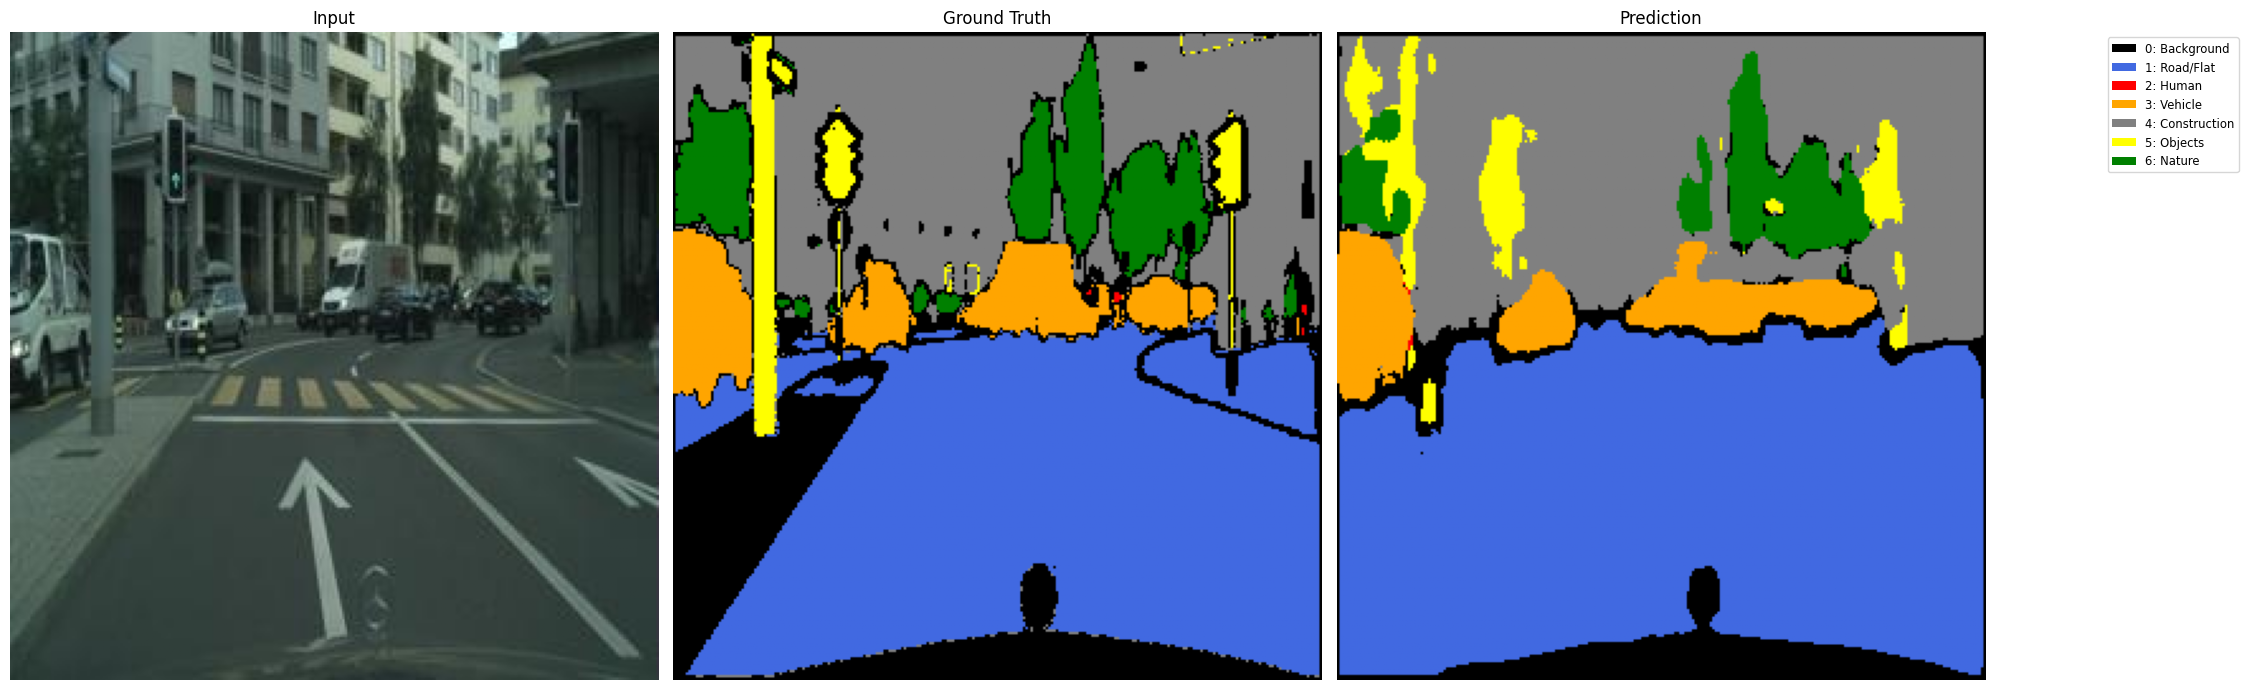

✅ Epoch 2 Complete | Avg Loss: 0.5713 | Avg mIoU: 0.6004
⭐ Refined Model Saved!


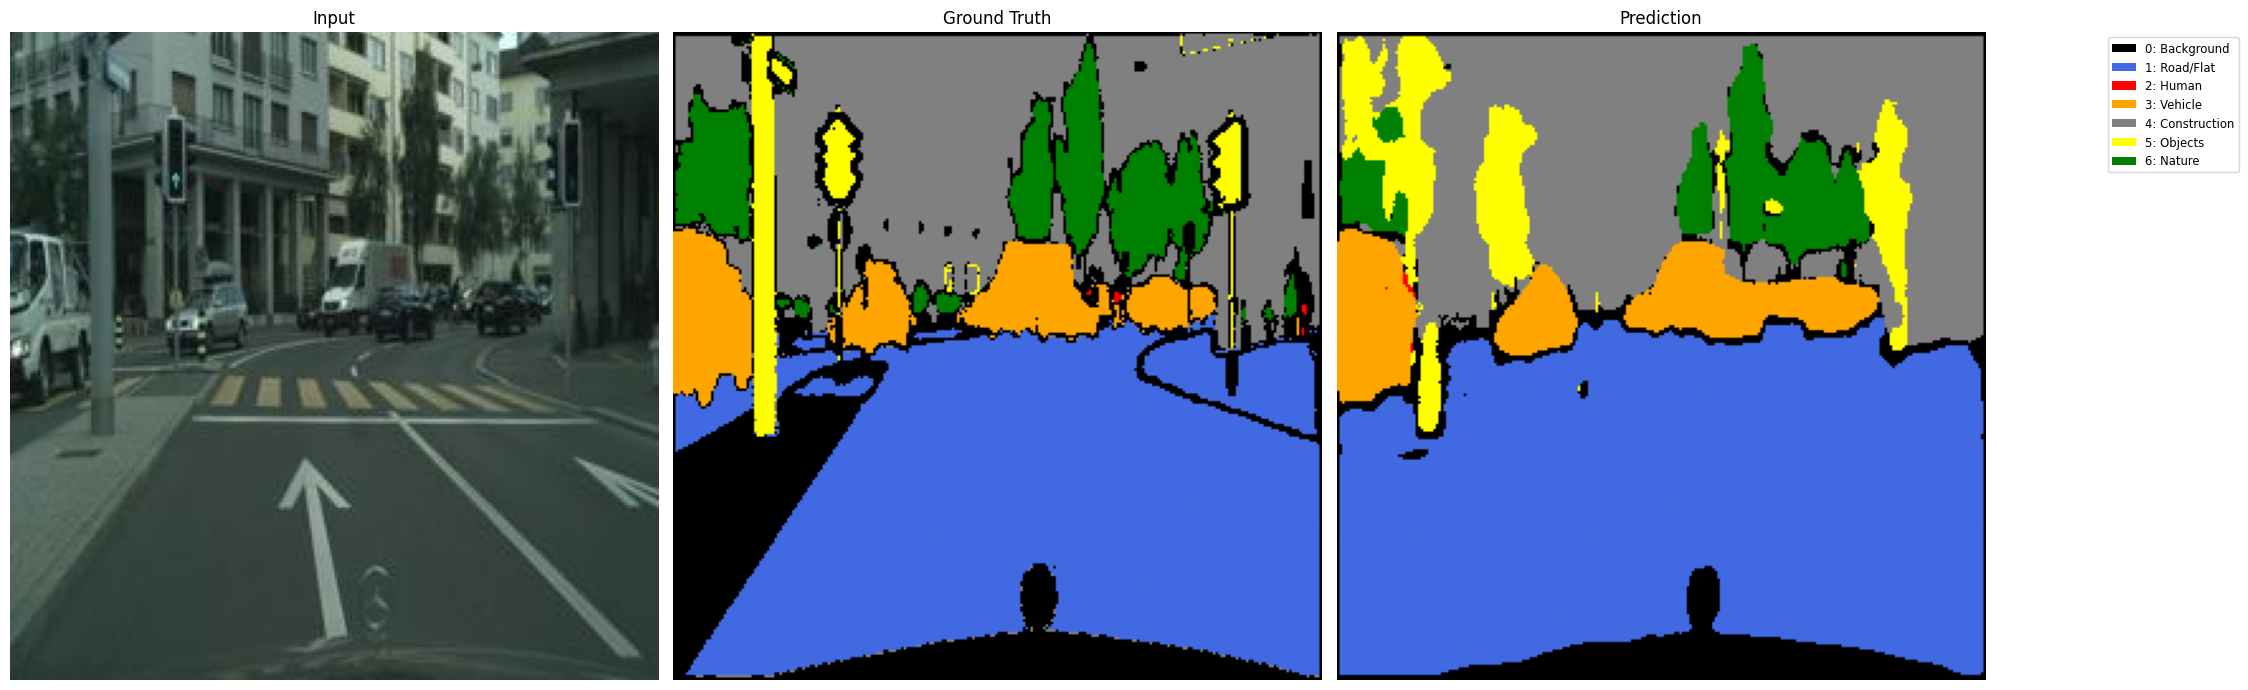

✅ Epoch 3 Complete | Avg Loss: 0.5410 | Avg mIoU: 0.6061
⭐ Refined Model Saved!


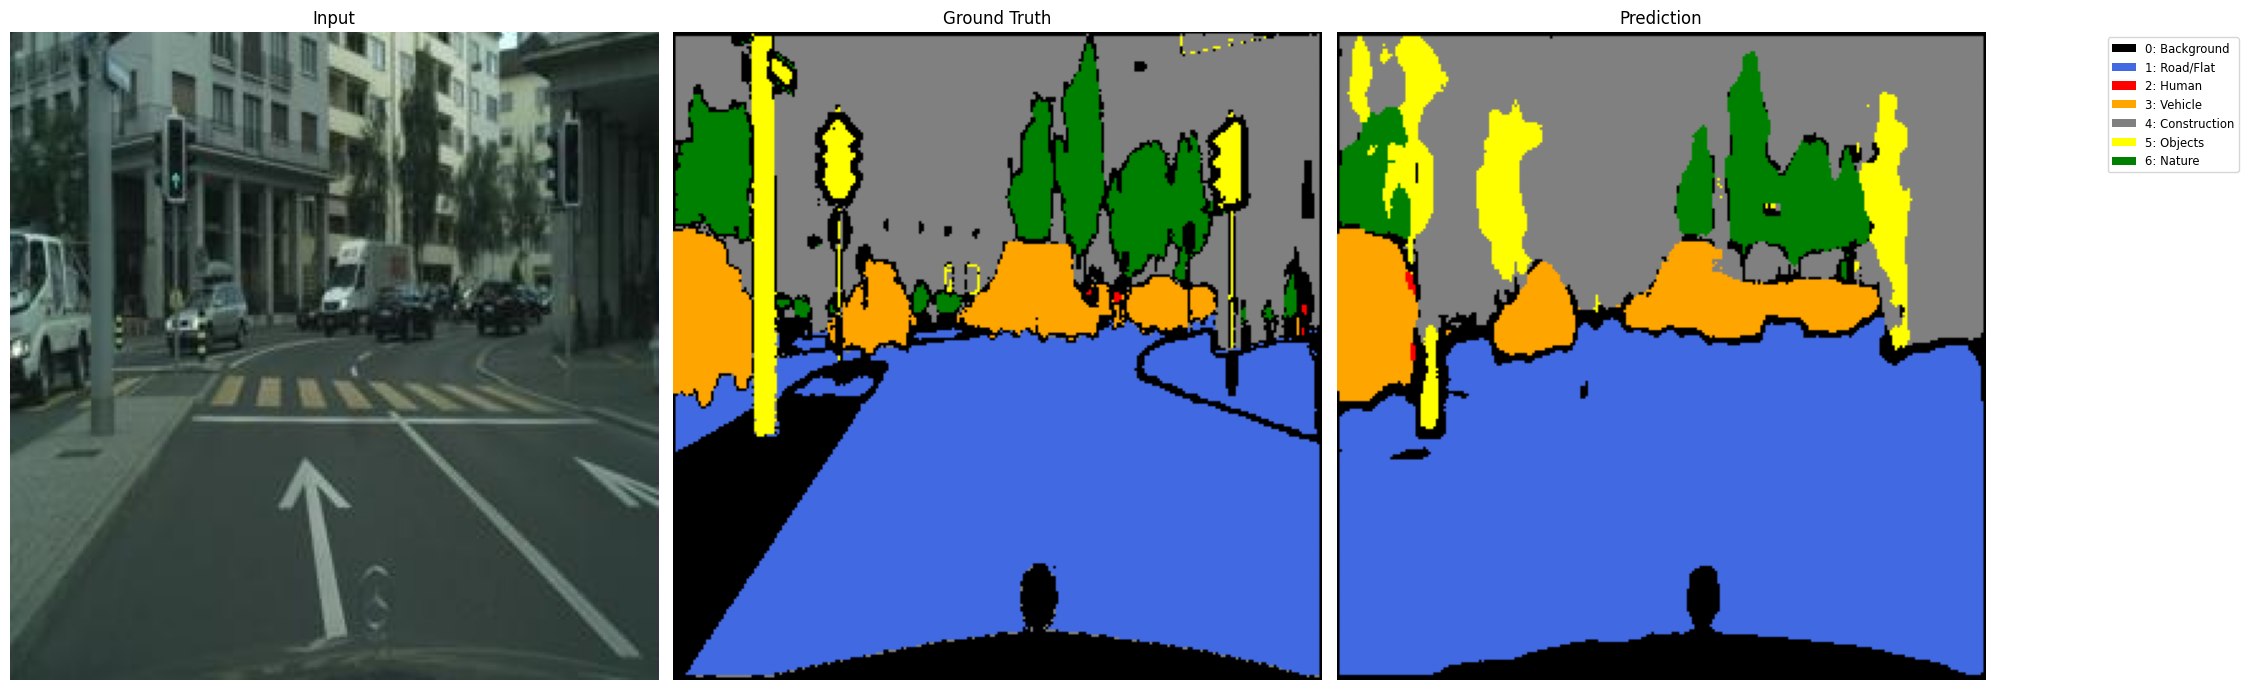

In [17]:
# --- EXECUTE COOL-DOWN TRAINING ---
EPOCHS_TO_RUN = 3
best_loss = float('inf')

print(f"❄️ Starting Refinement (Cool-Down) for {EPOCHS_TO_RUN} epochs...")

for epoch in range(EPOCHS_TO_RUN):
    avg_loss, avg_iou = train_one_epoch(model, train_loader, optimizer, criterion, epoch, EPOCHS_TO_RUN)
    
    print(f"✅ Epoch {epoch+1} Complete | Avg Loss: {avg_loss:.4f} | Avg mIoU: {avg_iou:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), '../models/cityscapes_refined.pth')
        print(f"⭐ Refined Model Saved!")

    visualize_prediction(model, train_ds, index=10)